In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [5]:
with zipfile.ZipFile(base_path + 'Cataract.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
splitfolders.ratio('/content/Cataract', output = 'Cataract_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 13758 files [00:02, 6771.05 files/s]


## Zero-Centering

In [7]:
train_path = '/content/Cataract_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [8]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [9]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [10]:
batch_size = 128

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [12]:
train_generator = train_datagen.flow_from_directory('/content/Cataract_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/Cataract_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/Cataract_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 11006 images belonging to 2 classes.
Found 1374 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


In [13]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50_zero = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 5s 0us/step


In [14]:
s_model_res50_zero.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [15]:
# tensorboard log 저장
model_name = 'Cataract_ZeroCentering'
current_time = datetime.datetime.now().strftime("%m%d%H%M") # Y : 연도 / m : 월 / d : 일 / H : 시 / M : 분 / S : 초
current_time

'03270136'

In [16]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ZeroCentering/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산

history = s_model_res50_zero.fit(train_generator, validation_data = val_generator, epochs = 10, callbacks=[board]) # 콜백 전달

Epoch 1/10
86/86 [==============================] - 66s 568ms/step - loss: 0.5334 - accuracy: 0.9533 - recall: 0.9478 - val_loss: 0.0193 - val_accuracy: 0.9949 - val_recall: 0.9971
Epoch 2/10
86/86 [==============================] - 40s 459ms/step - loss: 0.0125 - accuracy: 0.9968 - recall: 0.9965 - val_loss: 0.0159 - val_accuracy: 0.9971 - val_recall: 0.9956
Epoch 3/10
86/86 [==============================] - 45s 519ms/step - loss: 0.0115 - accuracy: 0.9964 - recall: 0.9964 - val_loss: 0.0066 - val_accuracy: 0.9971 - val_recall: 0.9956
Epoch 4/10
86/86 [==============================] - 41s 470ms/step - loss: 0.1077 - accuracy: 0.9870 - recall: 0.9873 - val_loss: 0.0124 - val_accuracy: 0.9971 - val_recall: 0.9956
Epoch 5/10
86/86 [==============================] - 46s 531ms/step - loss: 0.0089 - accuracy: 0.9980 - recall: 0.9976 - val_loss: 0.0053 - val_accuracy: 0.9978 - val_recall: 0.9956
Epoch 6/10
86/86 [==============================] - 41s 478ms/step - loss: 0.0016 - accuracy: 0

In [17]:
s_model_res50_zero.evaluate(test_generator)

11/11 [==============================] - 6s 571ms/step - loss: 2.8004e-04 - accuracy: 1.0000 - recall: 1.0000


[0.0002800405491143465, 1.0, 1.0]

In [36]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/Cataract_zero.h5'

# 모델 저장
s_model_res50_zero.save(model_path)

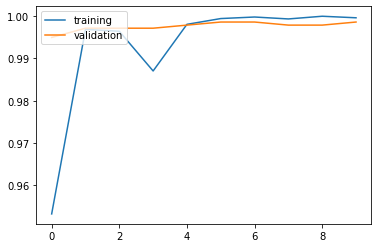

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

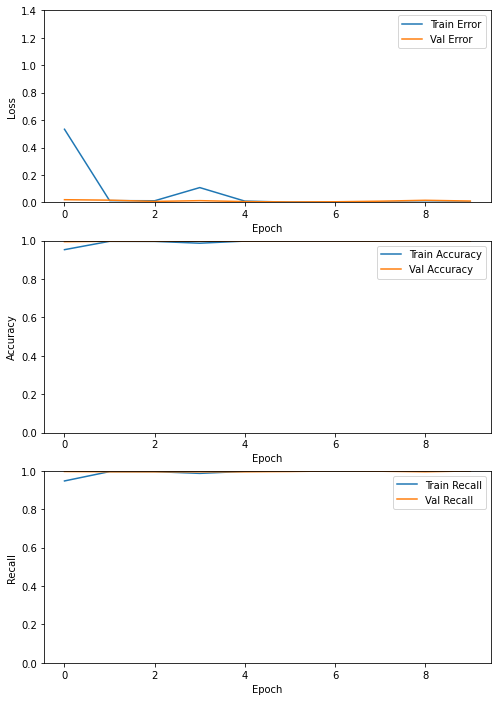

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## ImageDataGenerator 수정


In [16]:
# width_shift_range=0.1,
# height_shift_range=0.1,

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 이미지 데이터 제너레이터 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    preprocessing_function=sub_mean_img

)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)


In [23]:
train_generator = train_datagen.flow_from_directory('/content/Cataract_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/Cataract_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/Cataract_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 11006 images belonging to 2 classes.
Found 1374 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


In [24]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50 = tf.keras.Model(inputs, outputs)


In [25]:
s_model_res50.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [26]:
# tensorboard log 저장
model_name = 'Cataract_ImageDataGenerator'
current_time = datetime.datetime.now().strftime("%m%d%H%M") 

In [27]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ImageDataGenerator/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산

history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 10, callbacks=[board]) # 콜백 전달

Epoch 1/10
86/86 [==============================] - 137s 2s/step - loss: 0.9093 - accuracy: 0.5467 - recall: 0.5539 - val_loss: 0.9873 - val_accuracy: 0.5830 - val_recall: 0.9956
Epoch 2/10
86/86 [==============================] - 125s 1s/step - loss: 0.4947 - accuracy: 0.7661 - recall: 0.7943 - val_loss: 0.2613 - val_accuracy: 0.8996 - val_recall: 0.9534
Epoch 3/10
86/86 [==============================] - 130s 2s/step - loss: 0.3091 - accuracy: 0.8798 - recall: 0.8761 - val_loss: 0.2069 - val_accuracy: 0.9258 - val_recall: 0.8734
Epoch 4/10
86/86 [==============================] - 125s 1s/step - loss: 0.2393 - accuracy: 0.9096 - recall: 0.8942 - val_loss: 0.1533 - val_accuracy: 0.9432 - val_recall: 0.9214
Epoch 5/10
86/86 [==============================] - 129s 1s/step - loss: 0.1938 - accuracy: 0.9254 - recall: 0.9150 - val_loss: 0.1530 - val_accuracy: 0.9461 - val_recall: 0.9083
Epoch 6/10
86/86 [==============================] - 125s 1s/step - loss: 0.2024 - accuracy: 0.9265 - reca

In [28]:
s_model_res50.evaluate(test_generator)

11/11 [==============================] - 5s 390ms/step - loss: 0.1415 - accuracy: 0.9478 - recall: 0.9681


[0.14153443276882172, 0.9477503895759583, 0.9680696725845337]

In [37]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/Cataract_ImageDataGenerator.h5'

# 모델 저장
s_model_res50.save(model_path)

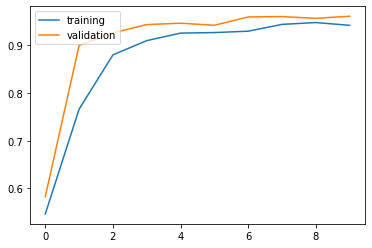

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

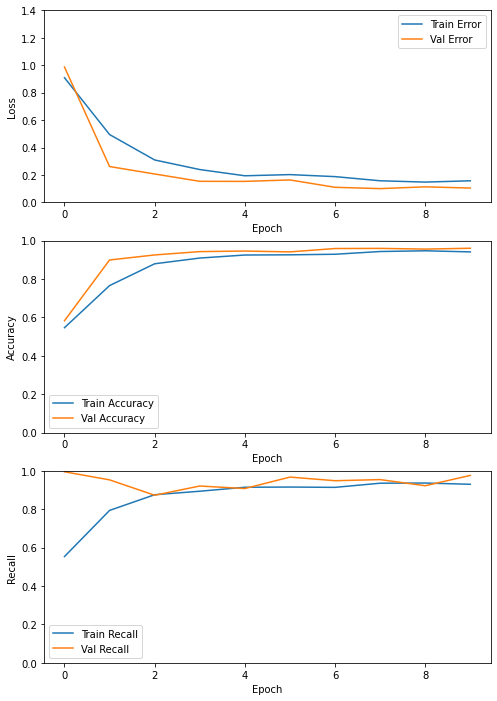

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)